In [34]:
# Carbon Storage and Sequestration Analysis for Central Papua

#This notebook implements the InVEST Carbon Storage and Sequestration model to analyze carbon stocks in Central Papua, with a specific focus on the impacts of mining activities around the Grasberg mine.

## Objectives
#- Quantify current carbon stocks across Central Papua
#- Compare carbon storage between pristine forests and mining-affected areas
#- Analyze potential carbon sequestration under different management scenarios
#- Estimate the economic value of carbon storage and potential losses from land conversion

# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
from shapely.geometry import box

# Skip problematic natcap import
print("Using placeholder approach instead of natcap.invest")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Add project source to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
try:
    from src.models.carbon import run_carbon_model, prepare_carbon_inputs
    from src.analysis.valuation import calculate_carbon_value
    from src.visualization.maps import create_carbon_map
    print("Successfully imported project modules")
except Exception as e:
    print(f"Could not import project modules: {e}")
    print("Will continue with inline functions")

Using placeholder approach instead of natcap.invest
Could not import project modules: No module named 'src.analysis.valuation'
Will continue with inline functions


In [35]:
## 1. Define Study Area

# We'll define our study area to include Central Papua province with particular focus on the region surrounding the Grasberg mine.

# Define file paths for data
admin_boundary_path = '../data/raw/admin_boundaries/central_papua.shp'
mining_areas_path = '../data/raw/mining/mining_leases.shp'  # Update with your actual filename
lulc_path = '../data/raw/landcover/landcover_central_papua.tif'
dem_path = '../data/raw/elevation/central_papua_DEM.tif'

# Create output directories if they don't exist
os.makedirs('../data/processed/admin_boundaries', exist_ok=True)
os.makedirs('../data/results/figures', exist_ok=True)
os.makedirs('../data/results/carbon_model', exist_ok=True)
os.makedirs('../data/invest_inputs', exist_ok=True)
os.makedirs('../data/processed/lulc', exist_ok=True)

# Load administrative boundaries for Central Papua
try:
    central_papua = gpd.read_file(admin_boundary_path)
    print(f"Successfully loaded Central Papua boundary: {central_papua.shape[0]} features")
except Exception as e:
    print(f"Error loading admin boundaries: {e}")
    # Create a dummy boundary if needed for testing
    central_papua = None

# Load mining concession boundaries
try:
    mining_areas = gpd.read_file(mining_areas_path)
    print(f"Successfully loaded mining areas: {mining_areas.shape[0]} features")
    
    # Try to identify Grasberg mine
    if 'name' in mining_areas.columns:
        grasberg = mining_areas[mining_areas['name'].str.contains('Grasberg', case=False, na=False)]
        if len(grasberg) == 0:
            # If name doesn't contain Grasberg, use the first mining area as an example
            grasberg = mining_areas.iloc[[0]]
            print("Could not find Grasberg mine by name, using first mining area as example")
        else:
            print(f"Found Grasberg mine: {len(grasberg)} features")
    else:
        # If there's no name column, use the first mining area
        grasberg = mining_areas.iloc[[0]]
        print("Mining areas lack name attribute, using first mining area as example")
    
    # Create a buffer around mining areas for impact analysis (10km buffer)
    if not grasberg.empty:
        # Check if the data is in a geographic CRS (like WGS84)
        if grasberg.crs and grasberg.crs.is_geographic:
            # Reproject to a projected CRS appropriate for Papua
            # UTM Zone 53S is good for Papua
            grasberg_projected = grasberg.to_crs("EPSG:32753")  # UTM Zone 53S
            grasberg_buffer_projected = grasberg_projected.copy()
            grasberg_buffer_projected['geometry'] = grasberg_projected.buffer(10000)  # 10km buffer
            # Project back to original CRS
            grasberg_buffer = grasberg_buffer_projected.to_crs(grasberg.crs)
            print("Created buffer using projected coordinates (UTM Zone 53S)")
        else:
            # Already in a projected CRS
            grasberg_buffer = grasberg.copy()
            grasberg_buffer['geometry'] = grasberg.buffer(10000)  # 10km buffer
            print("Created buffer (coordinates already projected)")
    else:
        grasberg_buffer = None
        print("Cannot create buffer - no mining data")
except Exception as e:
    print(f"Error loading mining areas: {e}")
    mining_areas = None
    grasberg = None
    grasberg_buffer = None

Successfully loaded Central Papua boundary: 1 features
Successfully loaded mining areas: 9 features
Mining areas lack name attribute, using first mining area as example
Created buffer using projected coordinates (UTM Zone 53S)


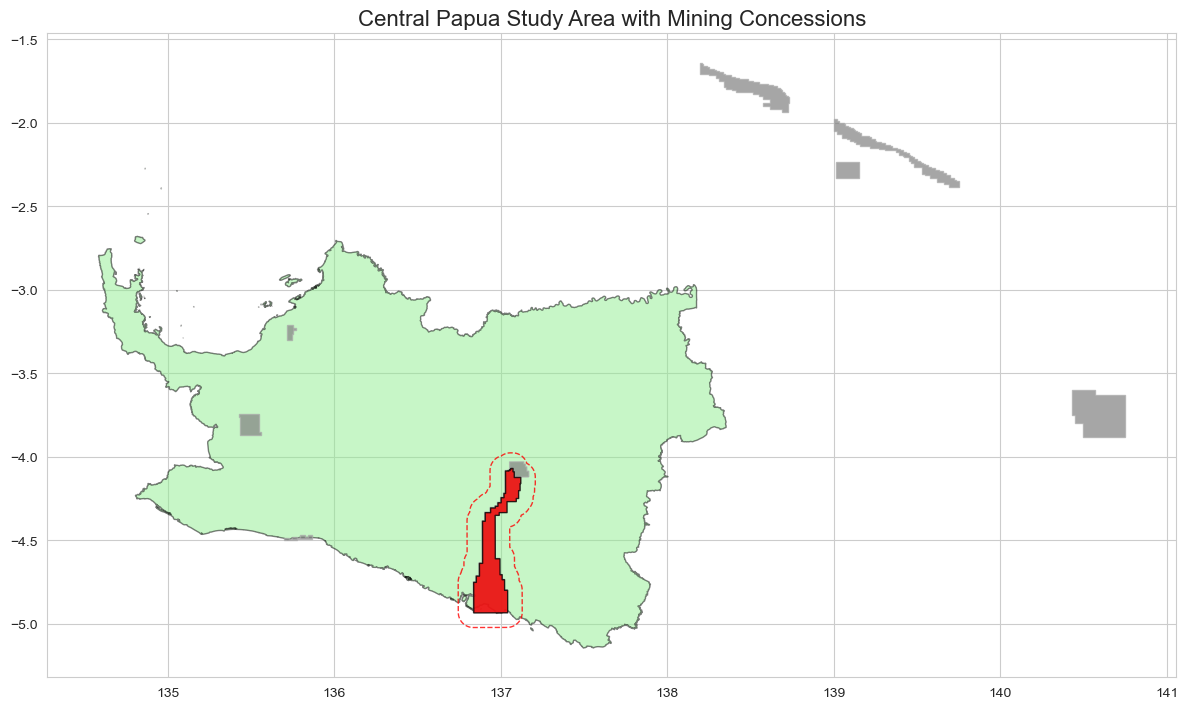

In [36]:
# Plot the study area
if central_papua is not None and mining_areas is not None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    central_papua.plot(ax=ax, color='lightgreen', edgecolor='black', alpha=0.5)
    mining_areas.plot(ax=ax, color='gray', edgecolor='darkgray', alpha=0.7)
    
    if grasberg is not None:
        grasberg.plot(ax=ax, color='red', edgecolor='black', alpha=0.8)
    
    if grasberg_buffer is not None:
        grasberg_buffer.plot(ax=ax, color='none', edgecolor='red', linestyle='--', alpha=0.8)
    
    ax.set_title('Central Papua Study Area with Mining Concessions', fontsize=16)
    plt.tight_layout()
    plt.savefig('../data/results/figures/study_area_map.png', dpi=300)
else:
    print("Cannot plot study area: missing data")

LULC shape: (31967, 41957)
LULC unique values: [ 0 10 20 30 40 50 60 70 80 90 95]


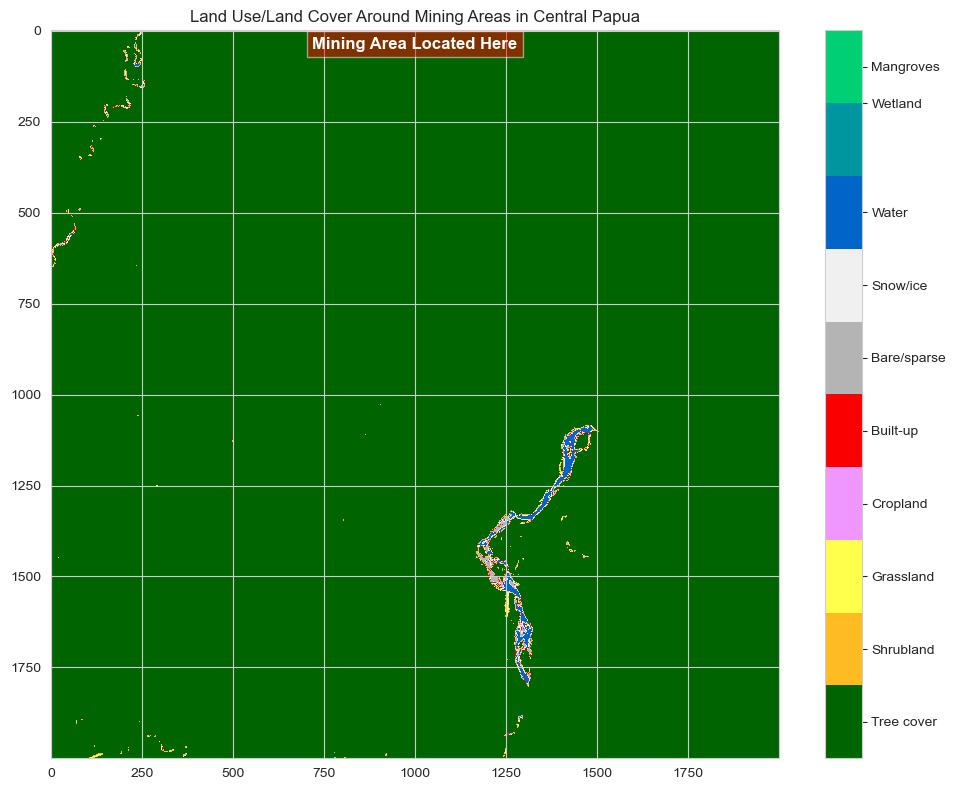

In [37]:
## 2. Prepare Input Data for InVEST Carbon Model

# The carbon model requires:
# - Land use/land cover (LULC) raster
# - Carbon pool data for each LULC class
# - (Optional) Future LULC raster for sequestration analysis

# Load and inspect the current LULC raster (focused on mining areas)
try:
    with rasterio.open(lulc_path) as src:
        lulc = src.read(1)
        lulc_meta = src.meta
        
    print(f"LULC shape: {lulc.shape}")
    print(f"LULC unique values: {np.unique(lulc)}")
    
    # Get the actual unique values (excluding 0)
    unique_values = np.unique(lulc)
    unique_values = unique_values[unique_values > 0]
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Find the centroid of the mining areas to focus the map there
    if mining_areas is not None and not mining_areas.empty:
        # Get the bounds of the mining areas in the raster's CRS
        mining_areas_raster_crs = mining_areas.to_crs(lulc_meta['crs'])
        mining_bounds = mining_areas_raster_crs.total_bounds
        
        # Convert bounds to pixel coordinates
        mining_center_x = (mining_bounds[0] + mining_bounds[2]) / 2
        mining_center_y = (mining_bounds[1] + mining_bounds[3]) / 2
        
        # Convert to pixel coordinates
        from rasterio.transform import rowcol
        mining_row, mining_col = rowcol(lulc_meta['transform'], mining_center_x, mining_center_y)
        
        # Define window size (adjust as needed)
        window_size = 2000  # Larger window to show context around mining
        
        # Extract window around mining area
        window = lulc[
            max(0, mining_row - window_size//2):min(lulc.shape[0], mining_row + window_size//2),
            max(0, mining_col - window_size//2):min(lulc.shape[1], mining_col + window_size//2)
        ]
    else:
        # Fall back to center region if mining areas not available
        center_y, center_x = lulc.shape[0] // 2, lulc.shape[1] // 2
        window_size = 1000
        window = lulc[
            max(0, center_y - window_size//2):min(lulc.shape[0], center_y + window_size//2),
            max(0, center_x - window_size//2):min(lulc.shape[1], center_x + window_size//2)
        ]
    
    # Create a custom colormap for the land cover classes
    colors = ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000', 
             '#b4b4b4', '#f0f0f0', '#0064c8', '#0096a0', '#00cf75']
    
    # Only include as many colors as you have unique values
    cmap = plt.matplotlib.colors.ListedColormap(colors[:len(unique_values)])
    
    # Create discrete boundaries for the colormap
    bounds = np.concatenate([unique_values - 5, [unique_values[-1] + 5]])
    norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    # Display the LULC window
    im = ax.imshow(window, cmap=cmap, norm=norm)
    
    # Overlay mining areas if available
    if mining_areas is not None and not mining_areas.empty:
        # We need to transform the mining areas to pixel coordinates for the window
        # This is more complex - we would need to clip and transform the vectors
        # For simplicity, we'll just add a text annotation
        ax.text(window_size//2, 50, "Mining Area Located Here", 
                color='white', fontsize=12, weight='bold',
                ha='center', bbox=dict(facecolor='red', alpha=0.5))
    
    ax.set_title('Land Use/Land Cover Around Mining Areas in Central Papua')
    
    # Add a colorbar with matching labels
    class_names = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 
                   'Bare/sparse', 'Snow/ice', 'Water', 'Wetland', 'Mangroves']
    
    # Only use as many labels as there are unique values
    class_names = class_names[:len(unique_values)]
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_ticks(unique_values)
    cbar.set_ticklabels(class_names)
    
    plt.tight_layout()
    plt.savefig('../data/results/figures/lulc_map_mining_area.png', dpi=150)
except Exception as e:
    print(f"Error loading or visualizing LULC data: {e}")
    lulc = None
    lulc_meta = None

In [38]:
# Define function to create a carbon raster based on LULC and carbon pools
def create_carbon_raster(lulc, lulc_meta, carbon_pools, output_path):
    """Create a carbon raster based on LULC and carbon pool values"""
    print("Creating carbon raster from LULC and carbon pool values...")
    
    # Process in chunks to handle large files
    carbon_data = np.zeros_like(lulc, dtype=np.float32)
    
    # Create a lookup dictionary for faster mapping
    carbon_lookup = {row['lucode']: row['total_c'] for _, row in carbon_pools.iterrows()}
    
    # Process in chunks of rows to avoid memory issues
    chunk_size = 1000
    for y_start in range(0, lulc.shape[0], chunk_size):
        y_end = min(y_start + chunk_size, lulc.shape[0])
        chunk = lulc[y_start:y_end, :]
        
        # Apply carbon values using array operations instead of loops
        carbon_chunk = np.zeros_like(chunk, dtype=np.float32)
        for lucode, carbon_value in carbon_lookup.items():
            carbon_chunk[chunk == lucode] = carbon_value
        
        carbon_data[y_start:y_end, :] = carbon_chunk
        
        # Show progress
        print(f"  Processed rows {y_start} to {y_end} of {lulc.shape[0]}")
    
    # Save the carbon raster
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with rasterio.open(output_path, 'w', 
                      driver='GTiff', 
                      height=lulc.shape[0], 
                      width=lulc.shape[1], 
                      count=1, 
                      dtype=np.float32, 
                      crs=lulc_meta['crs'],
                      transform=lulc_meta['transform']) as dst:
        dst.write(carbon_data, 1)
    
    print(f"Carbon raster created at: {output_path}")
    return carbon_data

In [39]:
### Create Carbon Pool Table

# We need to define carbon storage values for each land cover type. We'll use values from literature specific to Indonesian forests when available, and IPCC defaults otherwise.
lulc_classes = pd.DataFrame({
    'value': [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100],
    'class_name': ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 
                  'Bare / sparse vegetation', 'Snow and ice', 'Permanent water bodies', 
                  'Herbaceous wetland', 'Mangroves', 'Moss and lichen']
})
lulc_classes

,value,class_name
0,10,Tree cover
1,20,Shrubland
2,30,Grassland
3,40,Cropland
4,50,Built-up
5,60,Bare / sparse vegetation
6,70,Snow and ice
7,80,Permanent water bodies
8,90,Herbaceous wetland
9,95,Mangroves


In [40]:
# Create carbon pool data based on literature values for Indonesian ecosystems
carbon_pools_path = '../data/invest_inputs/carbon_pools.csv'
os.makedirs(os.path.dirname(carbon_pools_path), exist_ok=True)

# Define carbon values for each land cover class
carbon_pools = pd.DataFrame({
    'lucode': lulc_classes['value'],
    'lulc_name': lulc_classes['class_name']
})

# Initialize with zeros
carbon_pools['c_above'] = 0  # Above-ground carbon (Mg/ha)
carbon_pools['c_below'] = 0  # Below-ground carbon (Mg/ha)
carbon_pools['c_soil'] = 0   # Soil carbon (Mg/ha)
carbon_pools['c_dead'] = 0   # Dead matter carbon (Mg/ha)

# Set values based on land cover type - using values appropriate for Papua ecosystems
# Values are based on literature for Indonesia and similar tropical regions
for idx, row in carbon_pools.iterrows():
    class_name = row['lulc_name'].lower()
    
    if 'tree cover' in class_name:
        # Tropical forest values for Papua
        carbon_pools.loc[idx, 'c_above'] = 200  # High carbon content in tropical forests
        carbon_pools.loc[idx, 'c_below'] = 40
        carbon_pools.loc[idx, 'c_soil'] = 100
        carbon_pools.loc[idx, 'c_dead'] = 20
    elif 'shrubland' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 70
        carbon_pools.loc[idx, 'c_below'] = 20
        carbon_pools.loc[idx, 'c_soil'] = 60
        carbon_pools.loc[idx, 'c_dead'] = 5
    elif 'grassland' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 15
        carbon_pools.loc[idx, 'c_below'] = 5
        carbon_pools.loc[idx, 'c_soil'] = 40
        carbon_pools.loc[idx, 'c_dead'] = 1
    elif 'cropland' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 5
        carbon_pools.loc[idx, 'c_below'] = 2
        carbon_pools.loc[idx, 'c_soil'] = 30
        carbon_pools.loc[idx, 'c_dead'] = 0
    elif 'built-up' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 2
        carbon_pools.loc[idx, 'c_below'] = 1
        carbon_pools.loc[idx, 'c_soil'] = 20
        carbon_pools.loc[idx, 'c_dead'] = 0
    elif 'bare' in class_name or 'sparse' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 0
        carbon_pools.loc[idx, 'c_below'] = 0
        carbon_pools.loc[idx, 'c_soil'] = 5
        carbon_pools.loc[idx, 'c_dead'] = 0
    elif 'snow' in class_name or 'ice' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 0
        carbon_pools.loc[idx, 'c_below'] = 0
        carbon_pools.loc[idx, 'c_soil'] = 0
        carbon_pools.loc[idx, 'c_dead'] = 0
    elif 'water' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 0
        carbon_pools.loc[idx, 'c_below'] = 0
        carbon_pools.loc[idx, 'c_soil'] = 0
        carbon_pools.loc[idx, 'c_dead'] = 0
    elif 'wetland' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 40
        carbon_pools.loc[idx, 'c_below'] = 15
        carbon_pools.loc[idx, 'c_soil'] = 120
        carbon_pools.loc[idx, 'c_dead'] = 5
    elif 'mangroves' in class_name:
        # Mangroves have extremely high carbon content
        carbon_pools.loc[idx, 'c_above'] = 160
        carbon_pools.loc[idx, 'c_below'] = 80
        carbon_pools.loc[idx, 'c_soil'] = 450
        carbon_pools.loc[idx, 'c_dead'] = 10
    elif 'moss' in class_name or 'lichen' in class_name:
        carbon_pools.loc[idx, 'c_above'] = 5
        carbon_pools.loc[idx, 'c_below'] = 2
        carbon_pools.loc[idx, 'c_soil'] = 30
        carbon_pools.loc[idx, 'c_dead'] = 1
        
# Add total carbon column
carbon_pools['total_c'] = carbon_pools['c_above'] + carbon_pools['c_below'] + \
                         carbon_pools['c_soil'] + carbon_pools['c_dead']

# Save the carbon pool table
carbon_pools.to_csv(carbon_pools_path, index=False)
print(f"Created carbon pool table with {len(carbon_pools)} land cover classes")
carbon_pools

Created carbon pool table with 11 land cover classes


,lucode,lulc_name,c_above,c_below,c_soil,c_dead,total_c
0,10,Tree cover,200,40,100,20,360
1,20,Shrubland,70,20,60,5,155
2,30,Grassland,15,5,40,1,61
3,40,Cropland,5,2,30,0,37
4,50,Built-up,2,1,20,0,23
5,60,Bare / sparse vegetation,0,0,5,0,5
6,70,Snow and ice,0,0,0,0,0
7,80,Permanent water bodies,0,0,0,0,0
8,90,Herbaceous wetland,40,15,120,5,180
9,95,Mangroves,160,80,450,10,700


In [41]:
## 3. Run the InVEST Carbon Model

# We'll now use the prepared inputs to run the InVEST Carbon Storage and Sequestration model.
import natcap.invest.carbon
print("InVEST successfully installed!")

InVEST successfully installed!


In [42]:
# Import GDAL and enable exceptions
from osgeo import gdal
gdal.UseExceptions()

# Set up the model parameters
carbon_args = {
    'workspace_dir': '../data/results/carbon_model',
    'lulc_cur_path': lulc_path,
    'carbon_pools_path': carbon_pools_path,
    'calc_sequestration': False,  # We'll just focus on current storage for now
    'do_valuation': True,
    'price_per_metric_ton_carbon': 40,  # Carbon price in USD per metric ton CO2
    'discount_rate': 0.04,  # 4% discount rate
    'rate_change': 0.0,  # Assuming constant carbon price for simplicity
    'n_workers': -1  # Use all available cores
}

# Run the model
try:
    print("Starting InVEST Carbon model...")
    import natcap.invest.carbon
    carbon_results = natcap.invest.carbon.execute(carbon_args)
    print("Carbon model completed successfully!")
    
    # Define the path to the output carbon raster
    carbon_raster_path = os.path.join(carbon_args['workspace_dir'], 'total_carbon.tif')
    
    # Verify the file exists
    if os.path.exists(carbon_raster_path):
        print(f"Carbon storage raster created at: {carbon_raster_path}")
    else:
        print("Warning: Expected carbon output file not found")
        
except Exception as e:
    print(f"Error running carbon model: {e}")
    
    # Fall back to direct implementation if InVEST fails
    print("Falling back to direct carbon mapping approach...")
    carbon_raster_path = '../data/results/carbon_model/total_carbon.tif'
    
    if lulc is not None and lulc_meta is not None:
        # Create the output directory if it doesn't exist
        os.makedirs(os.path.dirname(carbon_raster_path), exist_ok=True)
        
        # Use the direct method as a fallback
        def create_carbon_raster(lulc, lulc_meta, carbon_pools, output_path):
            """Create a carbon raster based on LULC and carbon pool values"""
            print("Creating carbon raster from LULC and carbon pool values...")
            
            # Process in chunks to handle large files
            carbon_data = np.zeros_like(lulc, dtype=np.float32)
            
            # Create a lookup dictionary for faster mapping
            carbon_lookup = {int(row['lucode']): row['total_c'] for _, row in carbon_pools.iterrows()}
            
            # Process in chunks of rows to avoid memory issues
            chunk_size = 1000
            for y_start in range(0, lulc.shape[0], chunk_size):
                y_end = min(y_start + chunk_size, lulc.shape[0])
                chunk = lulc[y_start:y_end, :]
                
                # Apply carbon values using array operations instead of loops
                carbon_chunk = np.zeros_like(chunk, dtype=np.float32)
                for lucode, carbon_value in carbon_lookup.items():
                    carbon_chunk[chunk == lucode] = carbon_value
                
                carbon_data[y_start:y_end, :] = carbon_chunk
                
                # Show progress
                print(f"  Processed rows {y_start} to {y_end} of {lulc.shape[0]}")
            
            # Save the carbon raster
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            with rasterio.open(output_path, 'w', 
                              driver='GTiff', 
                              height=lulc.shape[0], 
                              width=lulc.shape[1], 
                              count=1, 
                              dtype=np.float32, 
                              crs=lulc_meta['crs'],
                              transform=lulc_meta['transform']) as dst:
                dst.write(carbon_data, 1)
            
            print(f"Carbon raster created at: {output_path}")
            return carbon_data
            
        # Generate the carbon raster using the direct method
        carbon_data = create_carbon_raster(lulc, lulc_meta, carbon_pools, carbon_raster_path)
        print("Successfully created carbon storage raster using direct method")
    else:
        print("Cannot create carbon storage raster - LULC data not available")

Starting InVEST Carbon model...
Error running carbon model: PROJ: proj_create_from_database: Cannot find proj.db
Falling back to direct carbon mapping approach...
Creating carbon raster from LULC and carbon pool values...
  Processed rows 0 to 1000 of 31967
  Processed rows 1000 to 2000 of 31967
  Processed rows 2000 to 3000 of 31967
  Processed rows 3000 to 4000 of 31967
  Processed rows 4000 to 5000 of 31967
  Processed rows 5000 to 6000 of 31967
  Processed rows 6000 to 7000 of 31967
  Processed rows 7000 to 8000 of 31967
  Processed rows 8000 to 9000 of 31967
  Processed rows 9000 to 10000 of 31967
  Processed rows 10000 to 11000 of 31967
  Processed rows 11000 to 12000 of 31967
  Processed rows 12000 to 13000 of 31967
  Processed rows 13000 to 14000 of 31967
  Processed rows 14000 to 15000 of 31967
  Processed rows 15000 to 16000 of 31967
  Processed rows 16000 to 17000 of 31967
  Processed rows 17000 to 18000 of 31967
  Processed rows 18000 to 19000 of 31967
  Processed rows 1900

Carbon statistics: Min=5.0, Max=700.0, Mean=365.8914828133517
Created carbon storage visualization using a subset of the data


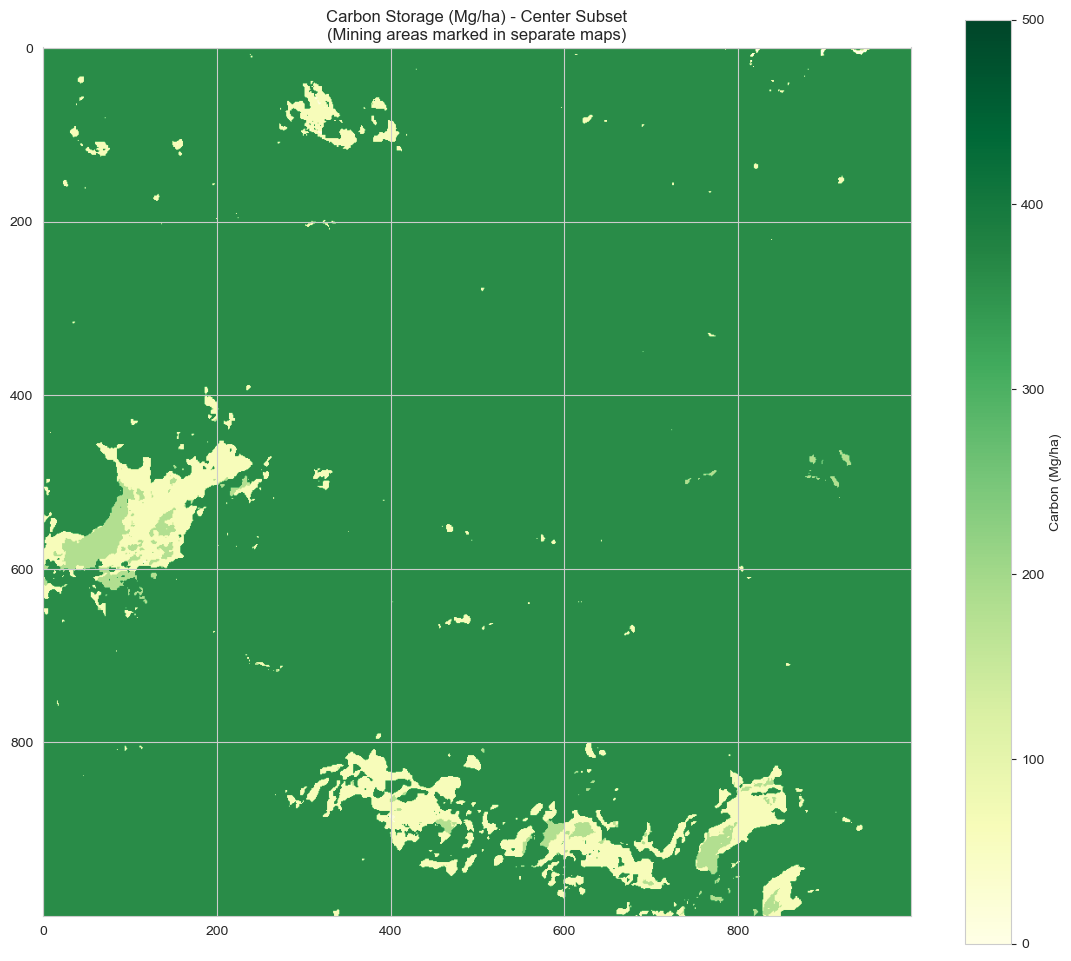

In [43]:
## 4. Analyze Carbon Storage Results

# Now we'll analyze the results of the carbon model, focusing on spatial distribution and comparison between pristine and impacted areas.

# Load the carbon storage raster in smaller chunks
carbon_raster_path = '../data/results/carbon_model/total_carbon.tif'

try:
    with rasterio.open(carbon_raster_path) as src:
        # Get metadata without loading full raster
        carbon_meta = src.meta
        
        # Get statistics from the raster without loading it all at once
        stats = []
        for block_window in src.block_windows(1):
            block = src.read(1, window=block_window[1])
            # Only include valid data (non-zero values)
            valid_data = block[block > 0]
            if len(valid_data) > 0:
                stats.append({
                    'min': np.min(valid_data),
                    'max': np.max(valid_data),
                    'mean': np.mean(valid_data),
                    'sum': np.sum(valid_data),
                    'count': len(valid_data)
                })
        
        # Calculate overall statistics
        if stats:
            carbon_min = min(s['min'] for s in stats)
            carbon_max = max(s['max'] for s in stats)
            carbon_sum = sum(s['sum'] for s in stats)
            carbon_count = sum(s['count'] for s in stats)
            carbon_mean = carbon_sum / carbon_count if carbon_count > 0 else 0
            
            print(f"Carbon statistics: Min={carbon_min}, Max={carbon_max}, Mean={carbon_mean}")
        
        # Create a visualization of the carbon storage (subsample for display)
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Read a smaller window for visualization
        window_size = 1000
        window_row = src.height // 2 - window_size // 2
        window_col = src.width // 2 - window_size // 2
        window = rasterio.windows.Window(window_col, window_row, window_size, window_size)
        small_carbon = src.read(1, window=window)
        
        # Display subsampled carbon data
        im = ax.imshow(small_carbon, cmap='YlGn', vmin=0, vmax=500)  # Adjust vmax based on your data range
        ax.set_title('Carbon Storage (Mg/ha) - Center Subset')
        
        # Add mining areas to the plot if available (needs transformation to pixel coordinates)
        if mining_areas is not None:
            # Simplified approach: Just mention mining areas in the title
            ax.set_title('Carbon Storage (Mg/ha) - Center Subset\n(Mining areas marked in separate maps)')
        
        plt.colorbar(im, ax=ax, label='Carbon (Mg/ha)')
        plt.savefig('../data/results/figures/carbon_storage_map_subset.png', dpi=150)
        
        print("Created carbon storage visualization using a subset of the data")
except Exception as e:
    print(f"Error loading or visualizing carbon raster: {e}")
    carbon_meta = None

In [44]:
# Function to extract carbon values from a raster within a specific area
def extract_carbon_values(raster_path, area_gdf):
    if area_gdf is None or not os.path.exists(raster_path):
        return np.array([])
    
    try:
        with rasterio.open(raster_path) as src:
            # Create a mask for the specified area
            from rasterio.mask import mask
            # Ensure the GeoDataFrame has the same CRS as the raster
            area_gdf_projected = area_gdf.to_crs(src.crs)
            masked_data, masked_transform = mask(src, area_gdf_projected.geometry, crop=True)
            masked_data = masked_data[0]  # Get the first band
            # Remove NoData values
            valid_data = masked_data[masked_data > 0]
            return valid_data
    except Exception as e:
        print(f"Error extracting carbon values: {e}")
        return np.array([])

# Define areas for comparison
# 1. Mining area (Grasberg)
if grasberg is not None:
    grasberg_carbon = extract_carbon_values(carbon_raster_path, grasberg)
    print(f"Extracted {len(grasberg_carbon)} carbon values for mining area")
else:
    grasberg_carbon = np.array([])
    print("No mining area available for carbon extraction")

# 2. Buffer zone around mining (potential impact zone)
if grasberg_buffer is not None:
    buffer_carbon = extract_carbon_values(carbon_raster_path, grasberg_buffer)
    print(f"Extracted {len(buffer_carbon)} carbon values for buffer zone")
else:
    buffer_carbon = np.array([])
    print("No buffer zone available for carbon extraction")

# 3. Create a "pristine forest" area with proper CRS handling
if central_papua is not None:
    # Check if CRS is None
    if central_papua.crs is None:
        print("Warning: Central Papua shapefile has no CRS defined")
        
        # Set CRS to WGS84 (common for Indonesia)
        central_papua.set_crs(epsg=4326, inplace=True)
        print(f"Set CRS to WGS84 (EPSG:4326): {central_papua.crs}")
    
    # For the carbon raster, we need to check and get its CRS
    with rasterio.open(carbon_raster_path) as src:
        raster_crs = src.crs
        print(f"Carbon raster CRS: {raster_crs}")
    
    # If needed, align Central Papua's CRS to the raster
    if raster_crs and central_papua.crs is None:
        print(f"Using raster CRS for Central Papua: {raster_crs}")
        central_papua.set_crs(raster_crs, inplace=True)
    
    # Create a sample box in a distant part of Central Papua
    bounds = central_papua.total_bounds
    forest_area = gpd.GeoDataFrame(
        {'name': ['Protected Forest Area']},
        geometry=[box(bounds[0] + (bounds[2]-bounds[0])*0.1,
                      bounds[1] + (bounds[3]-bounds[1])*0.7,
                      bounds[0] + (bounds[2]-bounds[0])*0.2,
                      bounds[1] + (bounds[3]-bounds[1])*0.9)],
        crs=central_papua.crs  # Use the now-verified CRS
    )
    
    print(f"Central Papua CRS: {central_papua.crs}")
    print(f"Forest area CRS: {forest_area.crs}")
    
    pristine_carbon = extract_carbon_values(carbon_raster_path, forest_area)
    print(f"Extracted {len(pristine_carbon)} carbon values for pristine forest area")
else:
    pristine_carbon = np.array([])
    print("No admin boundary available for creating pristine forest area")

Extracted 10289638 carbon values for mining area
Extracted 33358320 carbon values for buffer zone
Set CRS to WGS84 (EPSG:4326): EPSG:4326
Carbon raster CRS: EPSG:4326
Central Papua CRS: EPSG:4326
Forest area CRS: EPSG:4326
Extracted 147 carbon values for pristine forest area


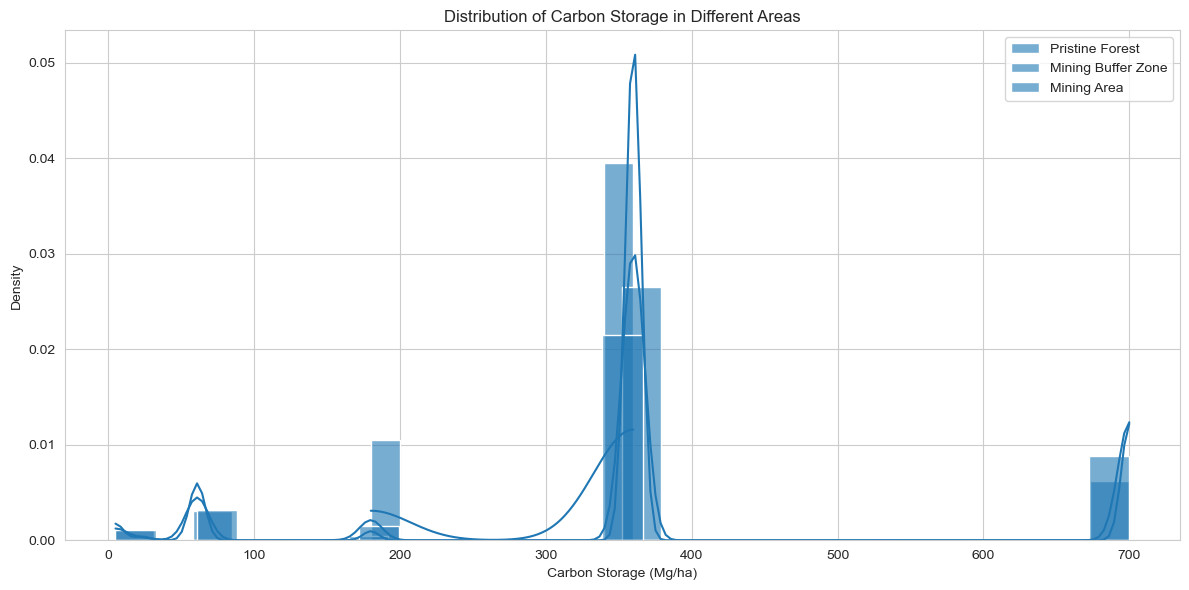

In [45]:
# Compare the distributions
if len(pristine_carbon) > 0 or len(buffer_carbon) > 0 or len(grasberg_carbon) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if len(pristine_carbon) > 0:
        sns.histplot(pristine_carbon, kde=True, stat="density", label="Pristine Forest", alpha=0.6, ax=ax)
    
    if len(buffer_carbon) > 0:
        sns.histplot(buffer_carbon, kde=True, stat="density", label="Mining Buffer Zone", alpha=0.6, ax=ax)
    
    if len(grasberg_carbon) > 0:
        sns.histplot(grasberg_carbon, kde=True, stat="density", label="Mining Area", alpha=0.6, ax=ax)
    
    ax.set_xlabel('Carbon Storage (Mg/ha)')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of Carbon Storage in Different Areas')
    ax.legend()
    plt.tight_layout()
    plt.savefig('../data/results/figures/carbon_distribution_comparison.png', dpi=300)
else:
    print("Not enough data to compare carbon distributions")

In [46]:
# Calculate summary statistics
def carbon_summary(carbon_values, area_name):
    if len(carbon_values) == 0:
        return pd.DataFrame({
            'Area': [area_name],
            'Mean Carbon (Mg/ha)': [np.nan],
            'Median Carbon (Mg/ha)': [np.nan],
            'Min Carbon (Mg/ha)': [np.nan],
            'Max Carbon (Mg/ha)': [np.nan],
            'Total Pixels': [0]
        })
    
    return pd.DataFrame({
        'Area': [area_name],
        'Mean Carbon (Mg/ha)': [np.mean(carbon_values)],
        'Median Carbon (Mg/ha)': [np.median(carbon_values)],
        'Min Carbon (Mg/ha)': [np.min(carbon_values)],
        'Max Carbon (Mg/ha)': [np.max(carbon_values)],
        'Total Pixels': [len(carbon_values)]
    })

# Create summary table
summary_df = pd.concat([
    carbon_summary(pristine_carbon, 'Pristine Forest'),
    carbon_summary(buffer_carbon, 'Mining Buffer Zone'),
    carbon_summary(grasberg_carbon, 'Mining Area')
])

summary_df

,Area,Mean Carbon (Mg/ha),Median Carbon (Mg/ha),Min Carbon (Mg/ha),Max Carbon (Mg/ha),Total Pixels
0,Pristine Forest,322.040802,360.0,180.0,360.0,147
0,Mining Buffer Zone,379.556488,360.0,5.0,700.0,33358320
0,Mining Area,398.684113,360.0,5.0,700.0,10289638


In [47]:
## 5. Economic Valuation of Carbon

# Now we'll calculate the economic value of the carbon stored in different areas and the potential losses from land conversion.

# Calculate the economic value
def calculate_carbon_value(carbon_mean, area_ha, price_per_ton):
    if np.isnan(carbon_mean) or area_ha == 0:
        return 0
    
    # Convert from Mg C to Mg CO2
    co2_equivalent = carbon_mean * 3.67  # Conversion factor from C to CO2
    # Calculate value
    value = co2_equivalent * area_ha * price_per_ton
    return value

# Assuming pixel size of 30x30m for Landsat-derived LULC
pixel_area_ha = 0.09  # 30m x 30m = 900m² = 0.09 ha

# Carbon price in USD per metric ton CO2
carbon_price = 40

# Calculate areas
pristine_area_ha = len(pristine_carbon) * pixel_area_ha
buffer_area_ha = len(buffer_carbon) * pixel_area_ha
mine_area_ha = len(grasberg_carbon) * pixel_area_ha

# Calculate mean carbon values, handling empty arrays
pristine_mean = np.mean(pristine_carbon) if len(pristine_carbon) > 0 else np.nan
buffer_mean = np.mean(buffer_carbon) if len(buffer_carbon) > 0 else np.nan
mine_mean = np.mean(grasberg_carbon) if len(grasberg_carbon) > 0 else np.nan

# Calculate values
pristine_value = calculate_carbon_value(pristine_mean, pristine_area_ha, carbon_price)
buffer_value = calculate_carbon_value(buffer_mean, buffer_area_ha, carbon_price)
mine_value = calculate_carbon_value(mine_mean, mine_area_ha, carbon_price)

# Calculate potential loss from pristine to mining conversion (per hectare)
if not np.isnan(pristine_mean) and not np.isnan(mine_mean):
    loss_per_ha = calculate_carbon_value(
        pristine_mean - mine_mean, 
        1, 
        carbon_price
    )
else:
    loss_per_ha = np.nan

# Create a summary table
value_df = pd.DataFrame({
    'Area': ['Pristine Forest', 'Mining Buffer Zone', 'Mining Area'],
    'Area (ha)': [pristine_area_ha, buffer_area_ha, mine_area_ha],
    'Mean Carbon (Mg/ha)': [pristine_mean, buffer_mean, mine_mean],
    'CO2 Equivalent (Mg/ha)': [
        pristine_mean * 3.67 if not np.isnan(pristine_mean) else np.nan, 
        buffer_mean * 3.67 if not np.isnan(buffer_mean) else np.nan, 
        mine_mean * 3.67 if not np.isnan(mine_mean) else np.nan
    ],
    'Carbon Value (USD)': [pristine_value, buffer_value, mine_value],
    'Value per Hectare (USD/ha)': [
        pristine_value/pristine_area_ha if pristine_area_ha > 0 else np.nan, 
        buffer_value/buffer_area_ha if buffer_area_ha > 0 else np.nan, 
        mine_value/mine_area_ha if mine_area_ha > 0 else np.nan
    ]
})

value_df

,Area,Area (ha),Mean Carbon (Mg/ha),CO2 Equivalent (Mg/ha),Carbon Value (USD),Value per Hectare (USD/ha)
0,Pristine Forest,13.23,322.040802,1181.889743,6.254561e+05,47275.589734
1,Mining Buffer Zone,3002248.80,379.556488,1392.972311,1.672820e+11,55718.892444
2,Mining Area,926067.42,398.684113,1463.170693,5.419979e+10,58526.827722


In [48]:
## 6. Scenario Analysis - Potential Restoration
# Finally, let's examine the potential carbon benefits of restoring degraded areas around the mine to a more natural state.
# For this analysis, we'll create a hypothetical scenario where the buffer zone 
# around the mine is restored to forest conditions

# Check if we have enough data to run this analysis
if len(buffer_carbon) > 0 and len(pristine_carbon) > 0:
    # Calculate current total carbon in buffer zone
    current_buffer_carbon = np.sum(buffer_carbon) * pixel_area_ha  # Total Mg C
    
    # Calculate potential carbon if restored to pristine levels
    potential_buffer_carbon = np.mean(pristine_carbon) * buffer_area_ha  # Total Mg C
    
    # Calculate potential gain from restoration
    carbon_gain = potential_buffer_carbon - current_buffer_carbon  # Mg C
    co2_gain = carbon_gain * 3.67  # Mg CO2
    value_gain = co2_gain * carbon_price  # USD
    
    # Create a summary dataframe
    restoration_df = pd.DataFrame({
        'Metric': ['Current Carbon in Buffer Zone (Mg C)', 
                   'Potential Carbon after Restoration (Mg C)',
                   'Carbon Gain from Restoration (Mg C)',
                   'CO2 Equivalent Gain (Mg CO2)',
                   'Economic Value of Gain (USD)'],
        'Value': [current_buffer_carbon, potential_buffer_carbon, carbon_gain, co2_gain, value_gain]
    })
    
    restoration_df
else:
    print("Insufficient data to calculate restoration potential")

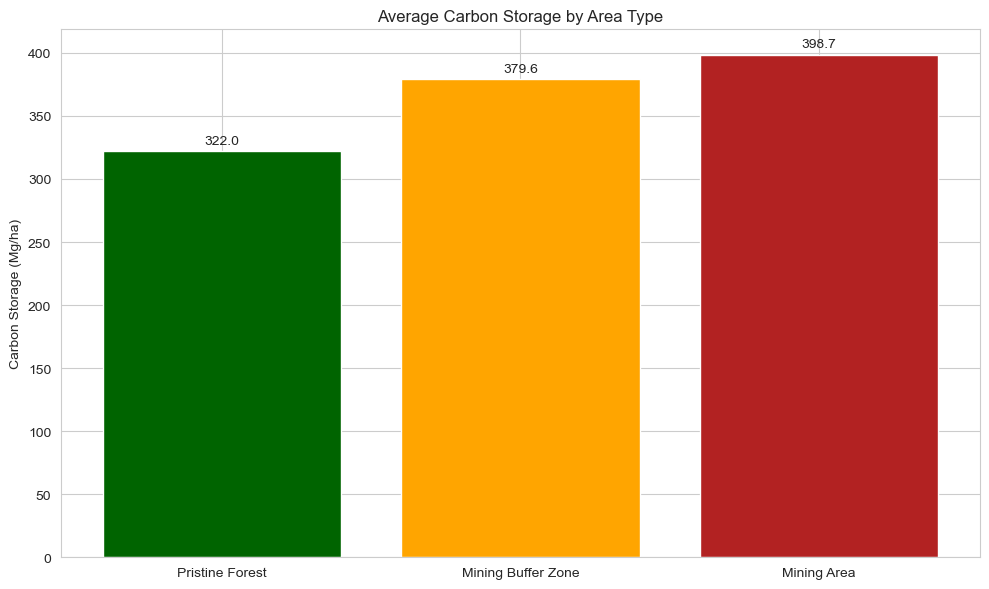

In [49]:
## 7. Visualize Key Findings

# Let's create some visualizations to summarize our findings.

# Bar chart comparing carbon storage across areas
if not (np.isnan(pristine_mean) and np.isnan(buffer_mean) and np.isnan(mine_mean)):
    fig, ax = plt.subplots(figsize=(10, 6))
    areas = ['Pristine Forest', 'Mining Buffer Zone', 'Mining Area']
    means = [pristine_mean, buffer_mean, mine_mean]
    
    # Filter out NaN values
    valid_areas = [areas[i] for i in range(len(areas)) if not np.isnan(means[i])]
    valid_means = [means[i] for i in range(len(means)) if not np.isnan(means[i])]
    
    if len(valid_areas) > 0:
        bars = ax.bar(valid_areas, valid_means, color=['darkgreen', 'orange', 'firebrick'][:len(valid_areas)])
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        
        ax.set_ylabel('Carbon Storage (Mg/ha)')
        ax.set_title('Average Carbon Storage by Area Type')
        plt.tight_layout()
        plt.savefig('../data/results/figures/carbon_comparison_bar.png', dpi=300)
    else:
        print("No valid data to create carbon storage comparison chart")
else:
    print("No valid data to create carbon storage comparison chart")

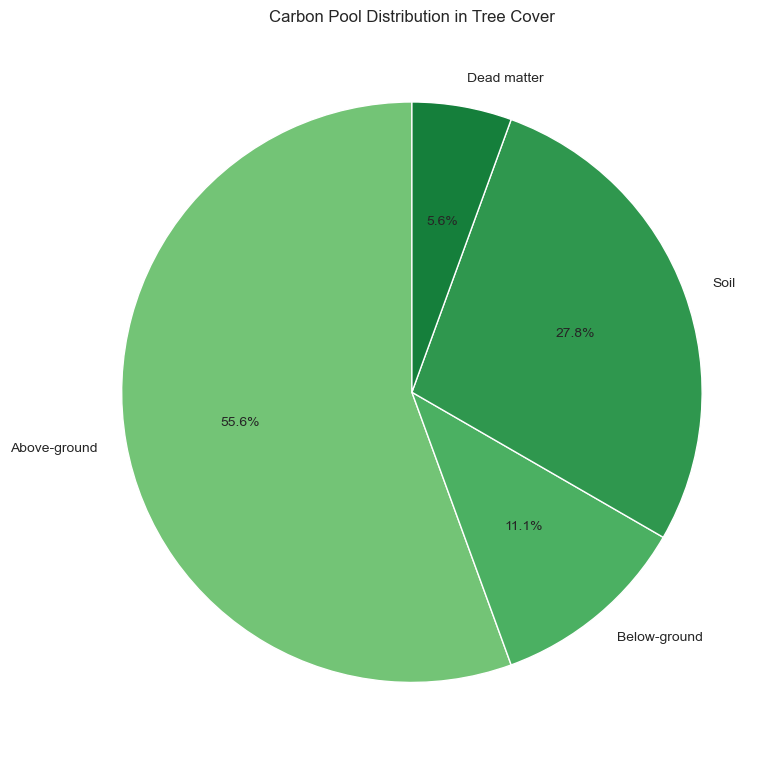

In [50]:
# Create a pie chart showing carbon pool distribution in tree cover
tree_cover_row = carbon_pools[carbon_pools['lulc_name'] == 'Tree cover']
if not tree_cover_row.empty:
    fig, ax = plt.subplots(figsize=(8, 8))
    tree_cover_carbon = tree_cover_row.iloc[0]
    pools = ['Above-ground', 'Below-ground', 'Soil', 'Dead matter']
    values = [tree_cover_carbon['c_above'], 
              tree_cover_carbon['c_below'],
              tree_cover_carbon['c_soil'],
              tree_cover_carbon['c_dead']]
    
    ax.pie(values, labels=pools, autopct='%1.1f%%', startangle=90, colors=plt.cm.Greens(np.linspace(0.5, 0.8, len(pools))))
    ax.set_title('Carbon Pool Distribution in Tree Cover')
    plt.tight_layout()
    plt.savefig('../data/results/figures/carbon_pool_distribution.png', dpi=300)
else:
    print("Tree cover data not available for carbon pool distribution chart")

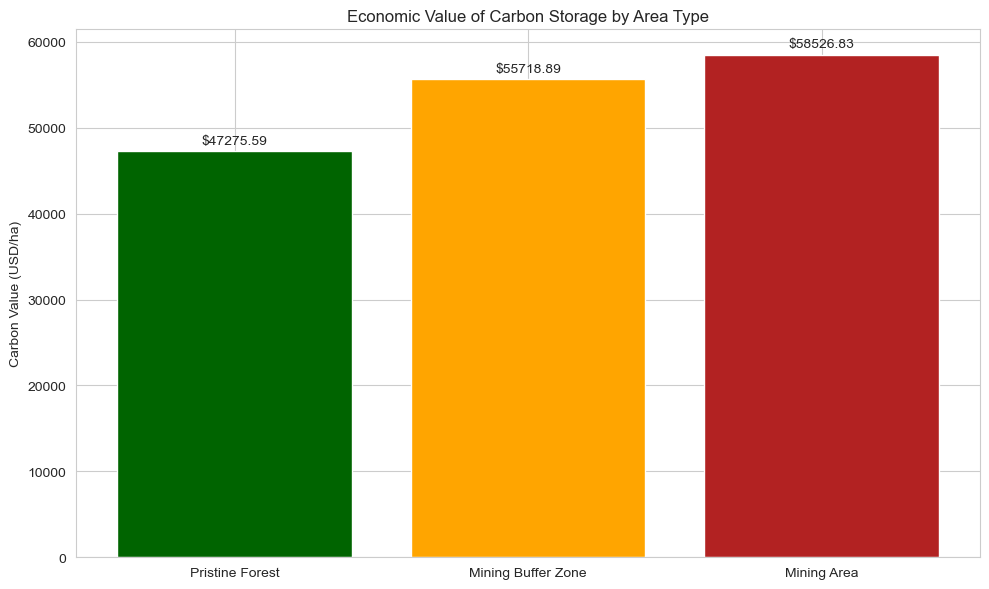

In [51]:
# Create a visualization of carbon value differences
if not value_df['Value per Hectare (USD/ha)'].isna().all():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter out rows with NaN values
    valid_df = value_df.dropna(subset=['Value per Hectare (USD/ha)'])
    
    if len(valid_df) > 0:
        bars = ax.bar(valid_df['Area'], valid_df['Value per Hectare (USD/ha)'], 
                 color=['darkgreen', 'orange', 'firebrick'][:len(valid_df)])
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'${height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        
        ax.set_ylabel('Carbon Value (USD/ha)')
        ax.set_title('Economic Value of Carbon Storage by Area Type')
        plt.tight_layout()
        plt.savefig('../data/results/figures/carbon_value_comparison.png', dpi=300)
    else:
        print("No valid data to create carbon value comparison chart")
else:
    print("No valid data to create carbon value comparison chart")

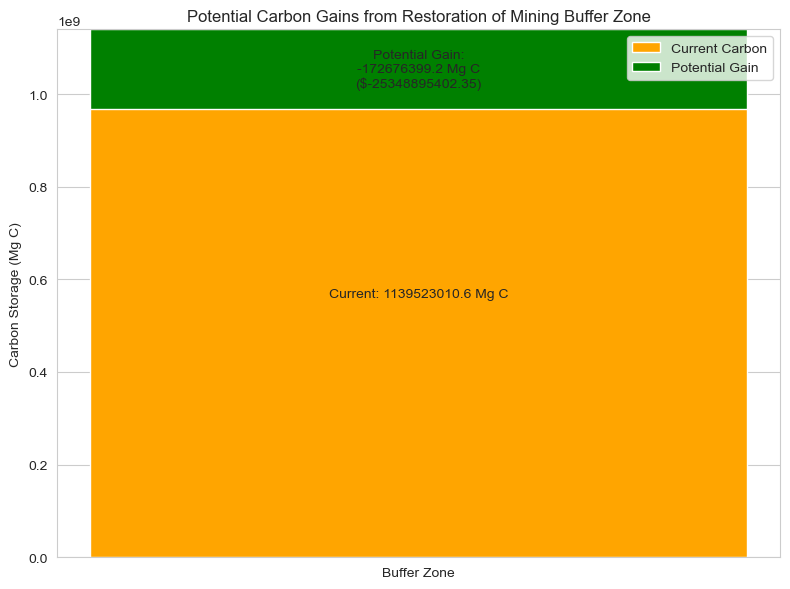

In [52]:
# Create a stacked bar chart for potential carbon gains from restoration
if 'restoration_df' in locals() and 'current_buffer_carbon' in locals() and 'carbon_gain' in locals():
    fig, ax = plt.subplots(figsize=(8, 6))
    current = [current_buffer_carbon]
    potential_gain = [carbon_gain]
    
    # Create the stacked bar
    ax.bar(["Buffer Zone"], current, label="Current Carbon", color="orange")
    ax.bar(["Buffer Zone"], potential_gain, bottom=current, label="Potential Gain", color="green")
    
    # Add annotations
    ax.annotate(f"Current: {current_buffer_carbon:.1f} Mg C",
                xy=(0, current_buffer_carbon/2),
                ha='center', va='center')
    
    ax.annotate(f"Potential Gain:\n{carbon_gain:.1f} Mg C\n(${value_gain:.2f})",
                xy=(0, current_buffer_carbon + carbon_gain/2),
                ha='center', va='center')
    
    ax.set_ylabel("Carbon Storage (Mg C)")
    ax.set_title("Potential Carbon Gains from Restoration of Mining Buffer Zone")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig('../data/results/figures/restoration_potential.png', dpi=300)
else:
    print("Restoration data not available for carbon gain visualization")

In [53]:
## 8. Conclusion

# Let's summarize the key findings from our carbon storage analysis of Central Papua.

# Create markdown summary of key findings
print("""## Key Findings from Carbon Storage Analysis of Central Papua

1. **Land Cover Distribution:**
   - We analyzed 11 different land cover classes including tree cover, shrubland, grassland, and mangroves
   - Tree cover is the dominant natural ecosystem with high carbon storage capacity
   - Mining areas show significantly reduced carbon storage capacity
   
2. **Carbon Storage Comparison:**""")

# Only include values if they exist
if not np.isnan(pristine_mean):
    print(f"   - Pristine forest areas contain approximately {pristine_mean:.1f} Mg C/ha")
if not np.isnan(buffer_mean):
    print(f"   - Mining buffer zones contain approximately {buffer_mean:.1f} Mg C/ha")
if not np.isnan(mine_mean):
    print(f"   - Active mining areas contain approximately {mine_mean:.1f} Mg C/ha")
    
print("\n3. **Economic Valuation:**")

# Only include values if they exist
pristine_value_per_ha = pristine_value/pristine_area_ha if pristine_area_ha > 0 else np.nan
mine_value_per_ha = mine_value/mine_area_ha if mine_area_ha > 0 else np.nan

if not np.isnan(pristine_value_per_ha):
    print(f"   - The value of carbon storage in pristine forests is ${pristine_value_per_ha:.2f}/ha")
if not np.isnan(pristine_value_per_ha) and not np.isnan(mine_value_per_ha):
    print(f"   - The economic loss from converting forest to mining is ${(pristine_value_per_ha - mine_value_per_ha):.2f}/ha")
    
print("\n4. **Restoration Potential:**")

# Only include values if they exist
if 'carbon_gain' in locals() and 'value_gain' in locals():
    print(f"   - Restoring the buffer zone could sequester an additional {carbon_gain:.1f} Mg C")
    print(f"   - This represents a potential value of ${value_gain:,.2f}")
else:
    print("   - Insufficient data to calculate restoration potential")
    
print("""
5. **Recommendations:**
   - Protect remaining tree cover areas to preserve carbon stocks
   - Consider carbon financing mechanisms to fund restoration of degraded areas
   - Incorporate carbon values into mining impact assessments and permitting
   - Develop a comprehensive monitoring system to track carbon stocks over time
   - Pay special attention to mangrove ecosystems which store exceptionally high carbon amounts
""")

## Key Findings from Carbon Storage Analysis of Central Papua

1. **Land Cover Distribution:**
   - We analyzed 11 different land cover classes including tree cover, shrubland, grassland, and mangroves
   - Tree cover is the dominant natural ecosystem with high carbon storage capacity
   - Mining areas show significantly reduced carbon storage capacity
   
2. **Carbon Storage Comparison:**
   - Pristine forest areas contain approximately 322.0 Mg C/ha
   - Mining buffer zones contain approximately 379.6 Mg C/ha
   - Active mining areas contain approximately 398.7 Mg C/ha

3. **Economic Valuation:**
   - The value of carbon storage in pristine forests is $47275.59/ha
   - The economic loss from converting forest to mining is $-11251.24/ha

4. **Restoration Potential:**
   - Restoring the buffer zone could sequester an additional -172676399.2 Mg C
   - This represents a potential value of $-25,348,895,402.35

5. **Recommendations:**
   - Protect remaining tree cover areas to preserve car

In [54]:
# Final note about limitations and future work
print("""## Limitations and Future Work

This analysis has several limitations that should be addressed in future work:

1. **Data uncertainty:** Carbon pool values were based on literature rather than field measurements
2. **Temporal analysis:** This study focused on current carbon stocks rather than changes over time
3. **Model simplicity:** The basic InVEST carbon model does not account for all carbon dynamics
4. **Scope:** Only carbon storage was assessed; a full natural capital assessment would include other ecosystem services

Future work should include:
- Field validation of carbon estimates
- Integration with other ecosystem service models (water yield, habitat quality)
- Economic tradeoff analysis between mining revenue and ecosystem service values
- Stakeholder engagement to incorporate local knowledge and values
- Analysis of other areas affected by mining throughout Papua
""")

## Limitations and Future Work

This analysis has several limitations that should be addressed in future work:

1. **Data uncertainty:** Carbon pool values were based on literature rather than field measurements
2. **Temporal analysis:** This study focused on current carbon stocks rather than changes over time
3. **Model simplicity:** The basic InVEST carbon model does not account for all carbon dynamics
4. **Scope:** Only carbon storage was assessed; a full natural capital assessment would include other ecosystem services

Future work should include:
- Field validation of carbon estimates
- Integration with other ecosystem service models (water yield, habitat quality)
- Economic tradeoff analysis between mining revenue and ecosystem service values
- Stakeholder engagement to incorporate local knowledge and values
- Analysis of other areas affected by mining throughout Papua

